In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import keras
from keras import optimizers
from keras.losses import categorical_crossentropy as logloss
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

from xception import Xception, preprocess_input

Using TensorFlow backend.


In [3]:
data_dir = '/home/ubuntu/data/'

In [4]:
data_generator = ImageDataGenerator(
    rotation_range=30, 
    zoom_range=0.3,
    horizontal_flip=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.001,
    channel_shift_range=0.1,
    fill_mode='reflect',
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

data_generator_val = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

train_generator = data_generator.flow_from_directory(
    data_dir + 'train_no_resizing', 
    target_size=(299, 299),
    batch_size=64
)

val_generator = data_generator_val.flow_from_directory(
    data_dir + 'val', shuffle=False,
    target_size=(299, 299),
    batch_size=64
)

Found 16980 images belonging to 256 classes.
Found 5120 images belonging to 256 classes.


# Model

In [5]:
model = Xception(weight_decay=1e-5)
model.count_params()

21386024

# Training

In [6]:
# add entropy to the usual logloss (it is for regularization),
# "Regularizing Neural Networks by Penalizing Confident Output Distributions",
# https://arxiv.org/abs/1701.06548
# it reduces overfitting a little bit
def loss(y_true, y_pred):
    entropy = -K.mean(K.sum(y_pred*K.log(y_pred), 1))
    beta = 0.1
    return logloss(y_true, y_pred) - beta*entropy

In [7]:
model.compile(
    optimizer=optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), 
    loss=loss, metrics=['categorical_crossentropy', 'accuracy', 'top_k_categorical_accuracy']
)

In [8]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=266, epochs=30, verbose=1,
    callbacks=[
        ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, epsilon=0.007),
        EarlyStopping(monitor='val_acc', patience=4, min_delta=0.01)
    ],
    validation_data=val_generator, validation_steps=80, workers=4
)

Epoch 1/30
266/266 [==============================] - 163s - loss: 3.5255 - categorical_crossentropy: 3.9596 - acc: 0.3337 - top_k_categorical_accuracy: 0.4732 - val_loss: 2.8166 - val_categorical_crossentropy: 3.2518 - val_acc: 0.5010 - val_top_k_categorical_accuracy: 0.7385
Epoch 2/30
266/266 [==============================] - 162s - loss: 1.9164 - categorical_crossentropy: 2.2452 - acc: 0.6309 - top_k_categorical_accuracy: 0.8255 - val_loss: 1.5650 - val_categorical_crossentropy: 1.8574 - val_acc: 0.6762 - val_top_k_categorical_accuracy: 0.8865
Epoch 3/30
266/266 [==============================] - 162s - loss: 1.3090 - categorical_crossentropy: 1.5465 - acc: 0.7198 - top_k_categorical_accuracy: 0.8929 - val_loss: 1.1246 - val_categorical_crossentropy: 1.3312 - val_acc: 0.7443 - val_top_k_categorical_accuracy: 0.9225
Epoch 4/30
266/266 [==============================] - 162s - loss: 1.0485 - categorical_crossentropy: 1.2293 - acc: 0.7621 - top_k_categorical_accuracy: 0.9169 - val_los

# Loss/epoch plots

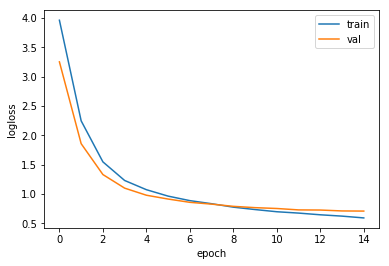

In [9]:
plt.plot(model.history.history['categorical_crossentropy'], label='train');
plt.plot(model.history.history['val_categorical_crossentropy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('logloss');

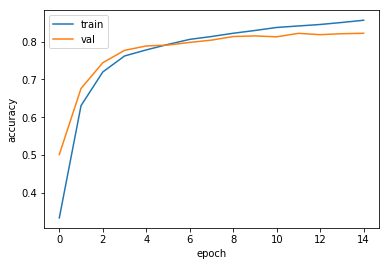

In [10]:
plt.plot(model.history.history['acc'], label='train');
plt.plot(model.history.history['val_acc'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

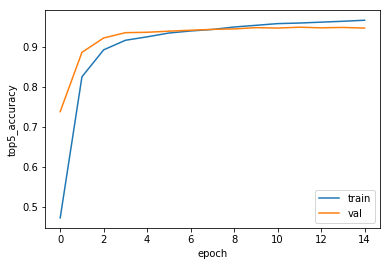

In [11]:
plt.plot(model.history.history['top_k_categorical_accuracy'], label='train');
plt.plot(model.history.history['val_top_k_categorical_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Results

In [12]:
model.evaluate_generator(val_generator, 80)

[0.65727720120921729, 0.70469321161508558, 0.8232421875, 0.94746093750000004]

In [13]:
model.save_weights('xception_weights.hdf5')